In [133]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [134]:
df = pd.read_csv('../data/dataset2.csv')

In [135]:
df.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [136]:
df.isnull().any()

Time                 True
Date                 True
Day of the week      True
CarCount             True
BikeCount            True
BusCount             True
TruckCount           True
Total                True
Traffic Situation    True
dtype: bool

In [137]:
df.dropna(inplace = True)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
2,12:30:00 AM,10.0,Tuesday,46.0,0.0,3.0,6.0,55.0,low
4,1:00:00 AM,10.0,Tuesday,57.0,6.0,15.0,16.0,94.0,normal
6,1:30:00 AM,10.0,Tuesday,37.0,0.0,1.0,4.0,42.0,low
7,1:45:00 AM,10.0,Tuesday,42.0,4.0,4.0,5.0,55.0,low
9,2:15:00 AM,10.0,Tuesday,34.0,0.0,4.0,7.0,45.0,low
...,...,...,...,...,...,...,...,...,...
6280,6:45:00 PM,5.0,Sunday,75.0,12.0,11.0,25.0,132.0,high
6282,5:00:00 PM,12.0,Thursday,107.0,24.0,31.0,4.0,163.0,high
6283,10:45:00 AM,4.0,Saturday,77.0,16.0,36.0,9.0,126.0,high
6284,3:30:00 PM,17.0,Tuesday,96.0,21.0,27.0,7.0,160.0,high


In [138]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trafficStatus = ['low', 'normal', 'high', 'heavy']

df['Time'] = pd.to_datetime(df['Time'], format="%I:%M:%S %p")
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Second'] = df['Time'].dt.second
df.drop(columns=['Time'], inplace=True)

df['Day of the week'] = df['Day of the week'].map(lambda x: days.index(x)).astype(int)
df['Traffic Situation'] = df['Traffic Situation'].map(lambda x: trafficStatus.index(x)).astype(int)

df

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Hour,Minute,Second
2,10.0,1,46.0,0.0,3.0,6.0,55.0,0,0,30,0
4,10.0,1,57.0,6.0,15.0,16.0,94.0,1,1,0,0
6,10.0,1,37.0,0.0,1.0,4.0,42.0,0,1,30,0
7,10.0,1,42.0,4.0,4.0,5.0,55.0,0,1,45,0
9,10.0,1,34.0,0.0,4.0,7.0,45.0,0,2,15,0
...,...,...,...,...,...,...,...,...,...,...,...
6280,5.0,6,75.0,12.0,11.0,25.0,132.0,2,18,45,0
6282,12.0,3,107.0,24.0,31.0,4.0,163.0,2,17,0,0
6283,4.0,5,77.0,16.0,36.0,9.0,126.0,2,10,45,0
6284,17.0,1,96.0,21.0,27.0,7.0,160.0,2,15,30,0


In [139]:
X = df.drop(columns=['Traffic Situation'])
y = df['Traffic Situation']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

with open("./NN/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

X_scaled

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Hour,Minute,Second
0,0.300000,0.166667,0.248649,0.000000,0.054545,0.139535,0.194346,0.000000,0.666667,0.0
1,0.300000,0.166667,0.308108,0.081081,0.272727,0.372093,0.332155,0.043478,0.000000,0.0
2,0.300000,0.166667,0.200000,0.000000,0.018182,0.093023,0.148410,0.043478,0.666667,0.0
3,0.300000,0.166667,0.227027,0.054054,0.072727,0.116279,0.194346,0.043478,1.000000,0.0
4,0.300000,0.166667,0.183784,0.000000,0.072727,0.162791,0.159011,0.086957,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...
3530,0.133333,1.000000,0.405405,0.162162,0.200000,0.581395,0.466431,0.782609,1.000000,0.0
3531,0.366667,0.500000,0.578378,0.324324,0.563636,0.093023,0.575972,0.739130,0.000000,0.0
3532,0.100000,0.833333,0.416216,0.216216,0.654545,0.209302,0.445230,0.434783,1.000000,0.0
3533,0.533333,0.166667,0.518919,0.283784,0.490909,0.162791,0.565371,0.652174,0.666667,0.0


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [141]:
# Dropout Layers and L2 Regularization
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.3),  # Dropout to reduce overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4, activation='softmax')
])

# Optimizer and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [142]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2968 - loss: 2.0716 - val_accuracy: 0.5551 - val_loss: 1.7292
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4586 - loss: 1.6489 - val_accuracy: 0.6004 - val_loss: 1.3587
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5844 - loss: 1.3340 - val_accuracy: 0.6192 - val_loss: 1.1462
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6023 - loss: 1.1726 - val_accuracy: 0.6315 - val_loss: 1.0549
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6545 - loss: 1.0794 - val_accuracy: 0.6635 - val_loss: 0.9832
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6795 - loss: 1.0127 - val_accuracy: 0.6730 - val_loss: 0.9483
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6912 - loss: 0.9883 - val_accuracy: 0.7154 - val_loss: 0.9013
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7030 - loss: 0.9512 - val_accuracy: 0.6890 - val_loss:

In [143]:
model.save("./NN/NN_model.keras")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8114 - loss: 0.6815 
Test Accuracy: 0.80


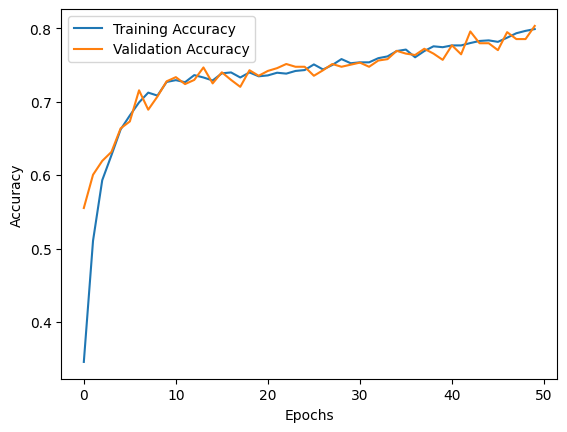

In [144]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


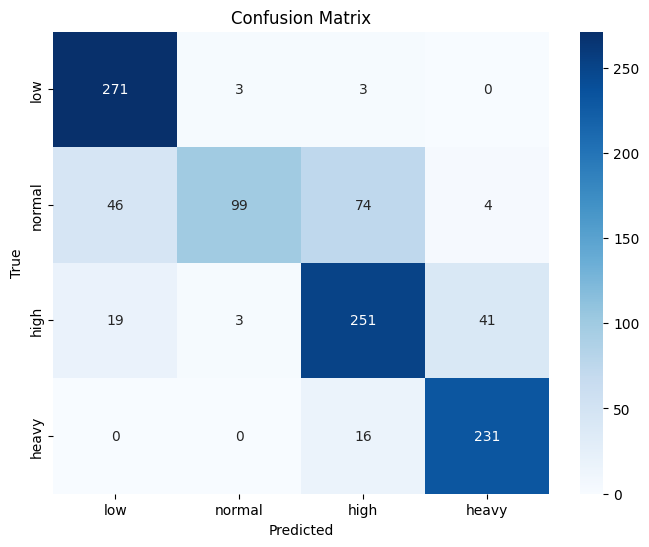

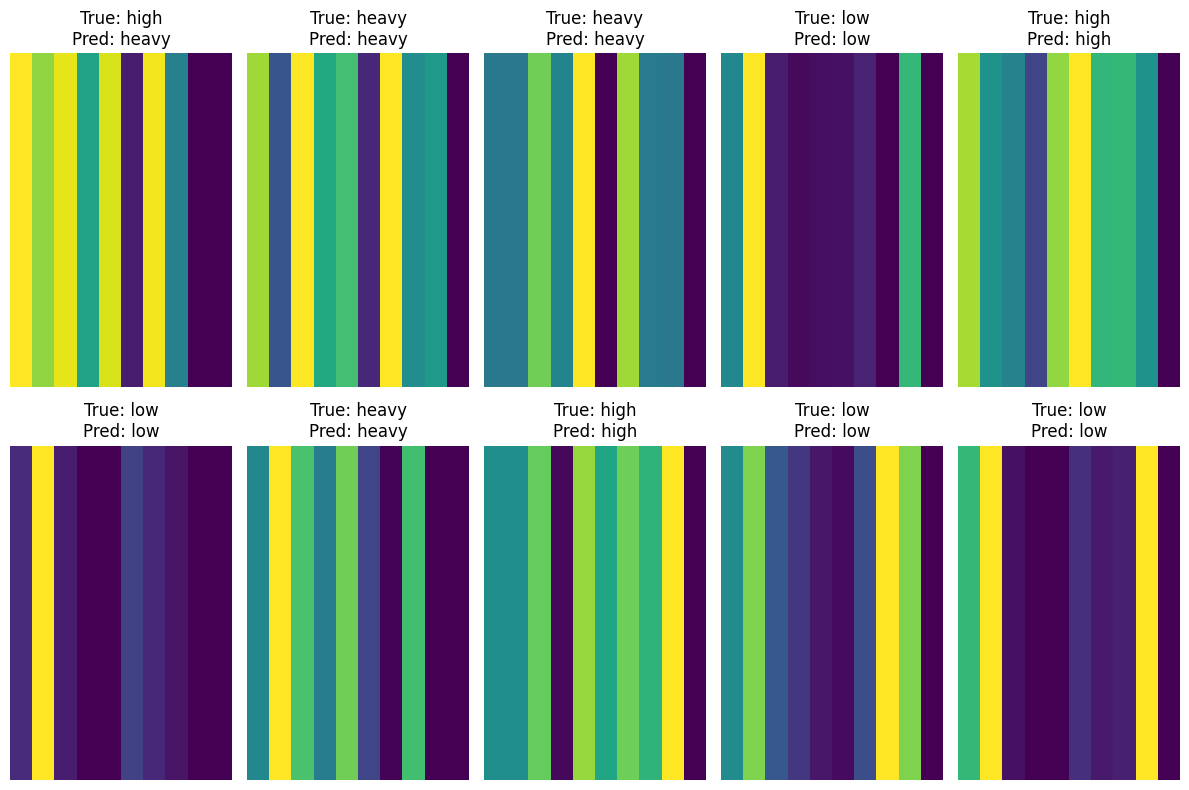

In [145]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_predictions(model, X_test, y_test):
    # Get the model predictions
    y_pred = model.predict(X_test)
    
    # Convert predictions from probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trafficStatus, yticklabels=trafficStatus)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot a few example predictions
    n = 10  # Number of samples to show
    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test.iloc[i].values.reshape(1, -1), cmap='viridis', aspect='auto')  # Visualize data
        plt.title(f'True: {trafficStatus[y_test_labels[i]]}\nPred: {trafficStatus[y_pred_labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_predictions(model, X_test, y_test)
